# Cliff Walking

On Barto & Sutton ther is a pretty cool example on the Q-learning chapter about the "cliff walking" where it is displayed the difference between SARSA and Q learning, lets try to recreate it here with our agents.

In [1]:
import sys 
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.q_agent import QAgent
from grid_world.agents.sarsa_agent import SarsaAgent
from grid_world.visualization.format_objects import get_policy_rec_str, get_policy_eval_str, get_world_str
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action

np.random.seed(21)

# World

This is the cliff world. There are many paths an agent may choose to take, the shortest one is to walk straight over the traps, however, this is unsafe as any "down" action taken by the agent will fall into the cliff. 

Since our agents follow an epsilon greedy policy while learning, they are bound to fall into the cliff from time. However we will see that the Q-learning doesn't care about this, since it learns to approximate the optimal value action estimator $q^\star$(its an off-policy method); on the other hand, SARSA is an on-policy method, meaning its $q$ function converges to its policy value action estimator. Since we are limiting the policy state to $\epsilon$-greedy policies(with fixed $\epsilon$) SARSA will at best learn the $q$ function for the best $\epsilon$-greedy policy.


I tried to use the same design as the one in the book, but they don't provide a value for $\alpha$. I reached 0.3 by trial and error, as it gave results similar to the ones in the book. 

In [2]:
y_size = 12
gworld = GridWorld(
    grid_shape=(4,y_size), 
    terminal_states_coordinates=((0,y_size-1),),
    traps_coordinates=tuple([(0,x+1) for x in range(y_size - 2)]),
)
print(get_world_str(gworld))

3                                    

2                                    

1                                    

0 ⚐  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ✘ 

  0  1  2  3  4  5  6  7  8  9  10  11 


In [3]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -100
    else:
        return -1

base_actions = [Action.up, Action.down, Action.left, Action.right]
epsilon = .1
alpha = .3

# Training the agents

Alright lets run some training rounds.

In [4]:
training_rounds = 50

q_returns = []

for _ in range(training_rounds):
    q_agent = QAgent(
        world = gworld,
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    q_episode_lengths, q_episode_returns = q_agent.train(episodes = 500)
    q_returns.append(q_episode_returns)
    
q_pi_r = get_policy_rec(q_agent.policy, gworld, q_agent.actions)
q_average_returns = np.mean(np.array(q_returns), axis=0)
q_std_returns = np.std(np.array(q_returns), axis=0)
print(get_policy_rec_str(q_pi_r, gworld))

 ↑  ↓  →  →  →  →  →  →  ↓  ↓  ↓  ↓ 

 ↓  ←  →  →  →  →  ↓  ↓  →  →  ↓  ↓ 

 →  →  →  →  →  →  →  →  →  →  →  ↓ 

 ↑  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ✘ 




In [5]:
sarsa_returns = []

for _ in range(training_rounds):

    sarsa_agent = SarsaAgent(
        world = gworld,
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    sarsa_episode_lengths, sarsa_episode_returns = sarsa_agent.train(episodes = 500)
    sarsa_returns.append(sarsa_episode_returns)
    
sarsa_pi_r = get_policy_rec(sarsa_agent.policy, gworld, sarsa_agent.actions)
sarsa_average_returns = np.mean(np.array(sarsa_returns), axis=0)
sarsa_std_returns = np.std(np.array(sarsa_returns), axis=0)
print(get_policy_rec_str(sarsa_pi_r, gworld))

 →  ↑  →  →  →  →  ↓  ↓  →  ↑  ↓  ↓ 

 →  →  →  →  →  →  →  →  →  →  ↓  ↓ 

 ↑  →  ↑  ↑  ↑  →  →  ↑  →  →  →  ↓ 

 ↑  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ✘ 




# Results

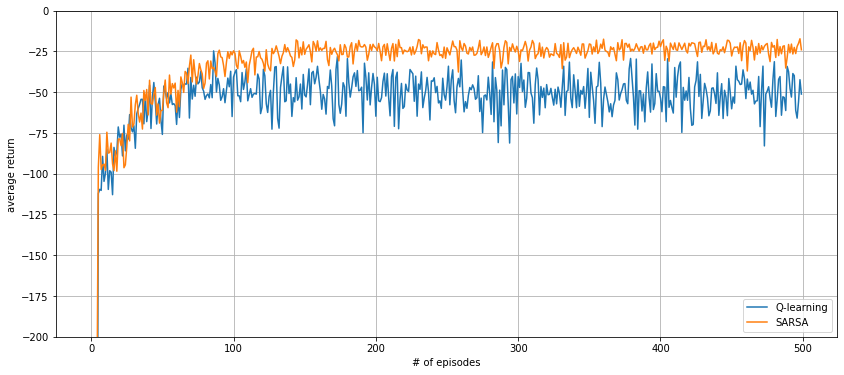

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(q_average_returns, label = "Q-learning")
ax.plot(sarsa_average_returns, label = "SARSA")

ax.set(
    xlabel='# of episodes', 
    ylabel='average return', 
    ylim=[-200, 0]
)
ax.grid()
ax.legend(loc="lower right")

plt.show()

Pretty cool, results go as expected. The q-agent learned the optimal policy, but has worse "on-line" performance(the performance during the learning episodes), while the SARSA agent learns a safer route. Both models also have trouble making decisions on states they are unlikely to visit, which is expected given the small number of episodes.

In the book it's suggested that the two initial actions under SARSA are "up"; this is not what I get when running 500 episodes. Bellow, I ran the algorithm a lot longer, and it eventually got to this policy. From a rough estimate, there isn't a big difference between returns for these policies, which makes learning this action hard for the agent. It seems to be the case that it needs good estimates for lots of state-action pairs before coming to this conclusion.

In [7]:
sarsa_agent = SarsaAgent(
    world = gworld,
    reward_function = reward,
    actions = base_actions,
    gamma = 1,
    alpha = alpha,
    epsilon = epsilon
)

long_sarsa_episode_lengths, long_sarsa_episode_returns = sarsa_agent.train(episodes = 20000)

sarsa_pi_r = get_policy_rec(sarsa_agent.policy, gworld, sarsa_agent.actions)
print(get_policy_rec_str(sarsa_pi_r, gworld))

 →  →  →  →  →  →  →  →  →  →  →  ↓ 

 ↑  →  ↑  →  ↑  ↑  →  ↑  ↑  ↑  →  ↓ 

 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  →  →  →  ↓ 

 ↑  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ✘ 




In [8]:
print(f""" 
Average returns of final 100 episodes

20000 episodes: {np.mean(long_sarsa_episode_returns[-100:]):.2f}
500 episodes: {np.mean(sarsa_episode_returns[-100:]):.2f}
""")

 
Average returns of final 100 episodes

20000 episodes: -20.54
500 episodes: -22.30



Also notice that using a lower value for $\epsilon$ the agent dooes not need to go all the way up, since probability of falling over the cliff gets smaller. 

In [9]:
le_sarsa_agent = SarsaAgent(
    world = gworld,
    reward_function = reward,
    actions = base_actions,
    gamma = 1,
    alpha = alpha,
    epsilon = 0.001
)

le_sarsa_episode_lengths, le_sarsa_episode_returns = le_sarsa_agent.train(episodes = 20000)

le_sarsa_pi_r = get_policy_rec(le_sarsa_agent.policy, gworld, le_sarsa_agent.actions)
print(get_policy_rec_str(le_sarsa_pi_r, gworld))

 ↑  →  ←  →  →  →  →  →  ↓  →  ↓  ↓ 

 →  →  →  →  →  →  →  →  →  →  →  ↓ 

 →  ↑  ↑  ↑  ↑  ↑  →  ↑  →  →  →  ↓ 

 ↑  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ☠  ✘ 


